In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [2]:
task = 'recipient'

time: 1.49 ms


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 16.5 s


In [4]:
l_b = plurality(d_b[task].dropna())
l_r = plurality(d_r[task].dropna())

time: 27.5 s


In [5]:
l_b.value_counts()

0.0    42871
1.0    10544
Name: y, dtype: int64

time: 5.29 ms


In [6]:
l_r.value_counts()

0.0    19833
1.0      160
Name: y, dtype: int64

time: 3.34 ms


In [7]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 685 ms


### Split into train/dev and test

In [8]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 43.4 ms


In [9]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 5.7 ms


In [10]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.7 ms


In [11]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

15

time: 31.6 ms


### NGram Classification Pipeline

In [33]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (0.0001, 0.01, 0.1, 1 ,5,10),
    #'clf__class_weight': ('balanced', None)
}

time: 6.26 ms


### Hyper-Parameter tuning

In [34]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)


Best parameters set found:
{'clf__C': 5, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'} 0.942947737662


Grid scores:
0.86564 (+/-0.00051) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.85497 (+/-0.00026) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.86205 (+/-0.00038) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 10000, 'vect__analyzer': 'char'}
0.87068 (+/-0.00055) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 50000, 'vect__analyzer': 'char'}
0.88167 (+/-0.00048) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.89039 (+/-0.00031) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.89365 (+/-0.00018) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_fea

In [19]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = None)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = None)),
])

time: 1.99 s


### Train on blocked

In [20]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 1min 25s


Eval on blocked


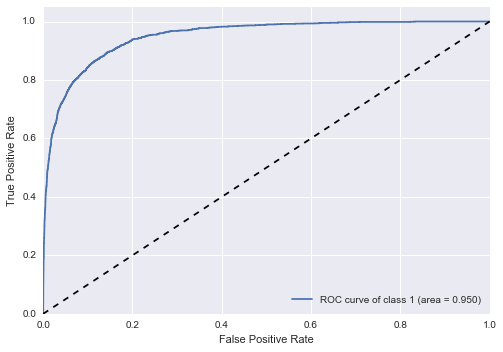

threshold @ optimal F1: 0.302955105619
{'accuracy': '0.908',
 'optimal F1': '0.768',
 'precision @ optimal F1': '0.775',
 'recall @ optimal F1': '0.775',
 'roc': '0.950'}
time: 17.5 s


In [21]:
print('Eval on blocked')
_= eval_binary_classifier(b_model, b_test, calibration = False, roc = True)

Eval on random


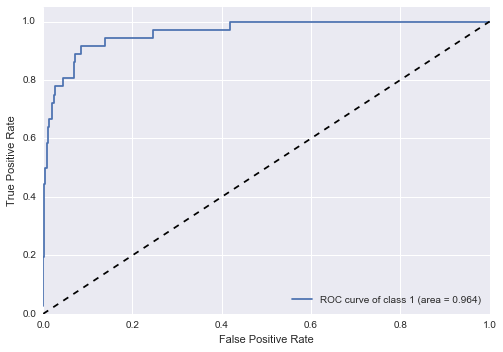

threshold @ optimal F1: 0.339723459751
{'accuracy': '0.992',
 'optimal F1': '0.474',
 'precision @ optimal F1': '0.500',
 'recall @ optimal F1': '0.500',
 'roc': '0.964'}
time: 7.11 s


In [22]:
print('Eval on random')
_= eval_binary_classifier(b_model, r_test, calibration = False, roc = True)

### Train on random

In [23]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 31.2 s


Eval on blocked


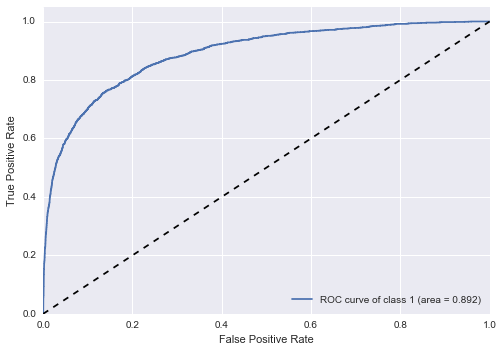

threshold @ optimal F1: 0.0183104589908
{'accuracy': '0.804',
 'optimal F1': '0.670',
 'precision @ optimal F1': '0.659',
 'recall @ optimal F1': '0.659',
 'roc': '0.892'}
time: 15.8 s


In [24]:
print('Eval on blocked')
_= eval_binary_classifier(r_model, b_test, calibration = False, roc = True)

Eval on random


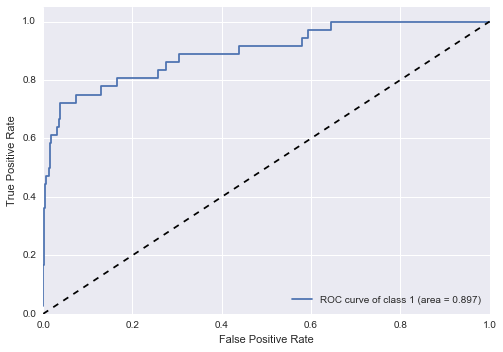

threshold @ optimal F1: 0.0193345489792
{'accuracy': '0.991',
 'optimal F1': '0.447',
 'precision @ optimal F1': '0.472',
 'recall @ optimal F1': '0.472',
 'roc': '0.897'}
time: 6.52 s


In [25]:
print('Eval on random')
_= eval_binary_classifier(r_model, r_test, calibration = False, roc = True)

### Train on both

In [26]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 1min 58s


Eval on blocked


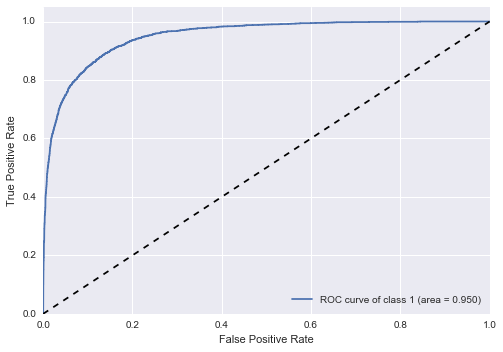

threshold @ optimal F1: 0.28211258212
{'accuracy': '0.907',
 'optimal F1': '0.770',
 'precision @ optimal F1': '0.776',
 'recall @ optimal F1': '0.776',
 'roc': '0.950'}
time: 17.8 s


In [27]:
print('Eval on blocked')
_= eval_binary_classifier(br_model, b_test, calibration = False, roc = True)

Eval on random


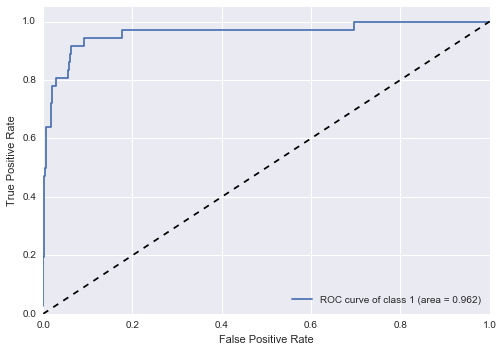

threshold @ optimal F1: 0.282819312058
{'accuracy': '0.992',
 'optimal F1': '0.474',
 'precision @ optimal F1': '0.500',
 'recall @ optimal F1': '0.500',
 'roc': '0.962'}
time: 6.79 s


In [28]:
print('Eval on random')
_= eval_binary_classifier(br_model, r_test, calibration = False, roc = True)

Eval on both


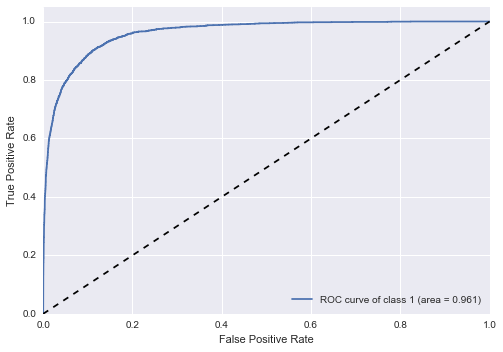

threshold @ optimal F1: 0.277506971447
{'accuracy': '0.930',
 'optimal F1': '0.765',
 'precision @ optimal F1': '0.776',
 'recall @ optimal F1': '0.776',
 'roc': '0.961'}
time: 22.6 s


In [29]:
print('Eval on both')
_= eval_binary_classifier(br_model, br_test, calibration = False, roc = True)

### Check Calibration

threshold @ optimal F1: 0.277506971447
{'accuracy': '0.930',
 'optimal F1': '0.765',
 'precision @ optimal F1': '0.776',
 'recall @ optimal F1': '0.776',
 'roc': '0.961'}


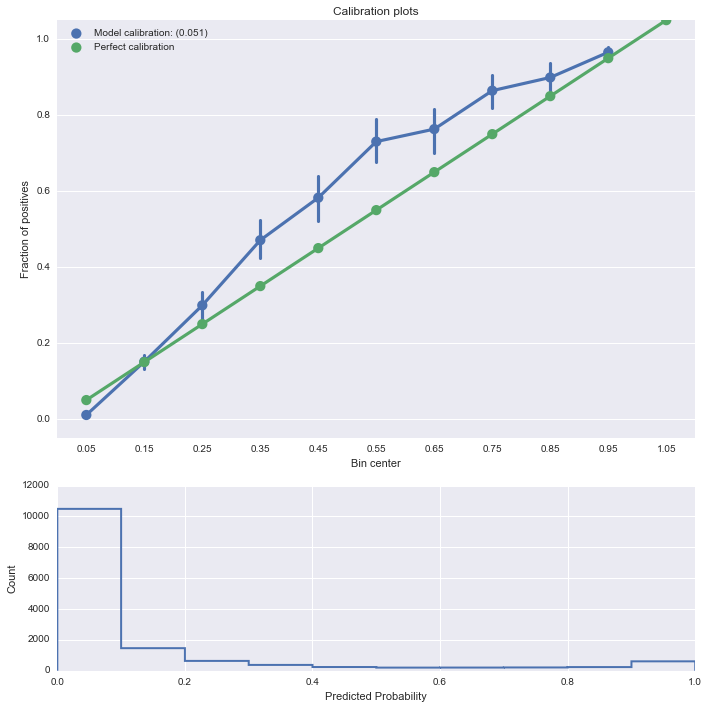

time: 24.8 s


In [30]:
_= eval_binary_classifier(br_model, br_test, calibration = True, roc = False)

threshold @ optimal F1: 0.28211258212
{'accuracy': '0.907',
 'optimal F1': '0.770',
 'precision @ optimal F1': '0.776',
 'recall @ optimal F1': '0.776',
 'roc': '0.950'}


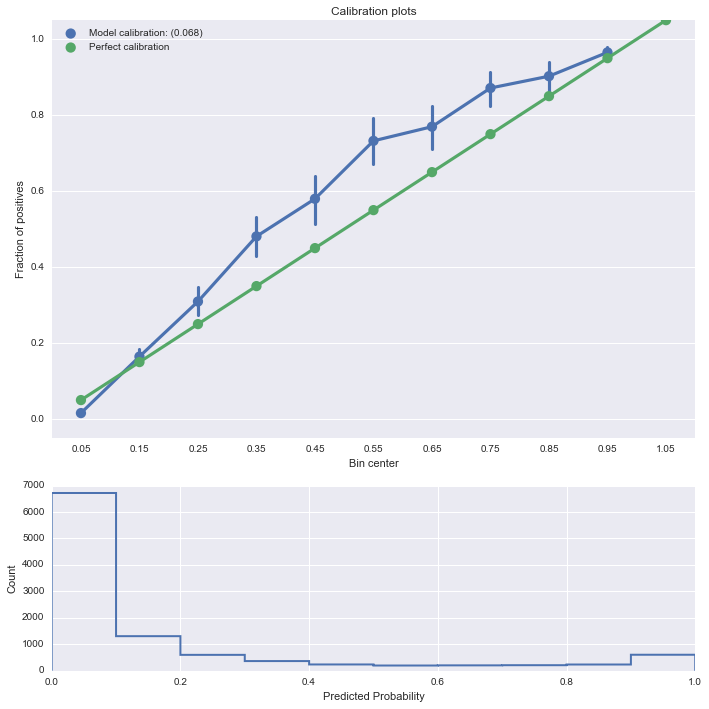

time: 17.1 s


In [31]:
_= eval_binary_classifier(br_model, b_test, calibration = True, roc = False)

threshold @ optimal F1: 0.282819312058
{'accuracy': '0.992',
 'optimal F1': '0.474',
 'precision @ optimal F1': '0.500',
 'recall @ optimal F1': '0.500',
 'roc': '0.962'}


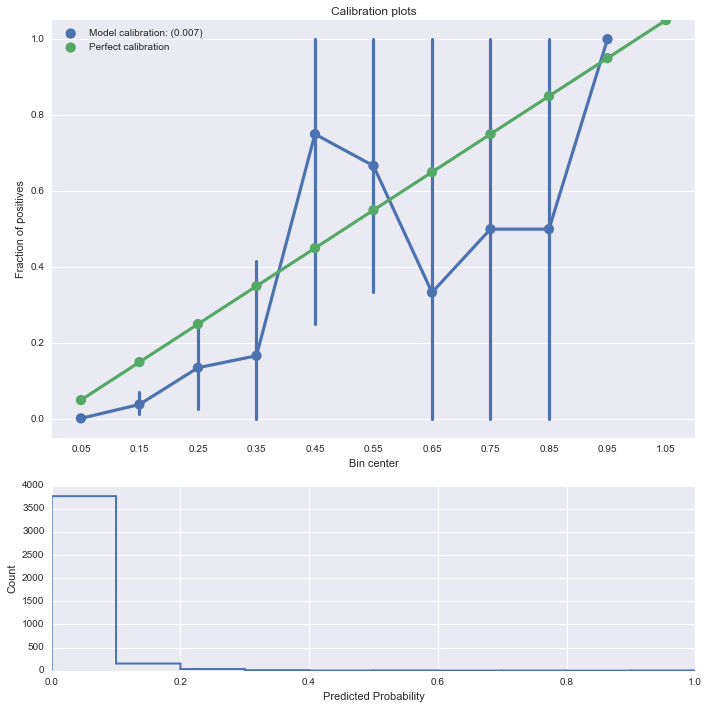

time: 7.62 s


In [32]:
_= eval_binary_classifier(br_model, r_test, calibration = True, roc = False)

### Error Analysis

In [33]:
fn, fp = get_clf_errors(br_model, br_test)

time: 44.3 s


In [34]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
" Please do not vandalize pages, as you did with this edit to Pimp C. If you continue to do so, you will be blocked from editing.  '''''''''' Speak. 02:26, 16 May 2009 (UTC)"
SCORES: Actual: 1, Predicted: 0, Score: 0.01


COMMENT:
 Personal Attacks? Thanks, your comment would have been much more meaningful if that was still on my page, but it was deleted a while ago. Bu thanks for trying. )  
SCORES: Actual: 1, Predicted: 0, Score: 0.01


COMMENT:
", 27 June 2009 (UTC)I think Singer only looked at gravitational redshift,  while  Winterberg  considered both the gravitational redshift and ""orbital"" time dilation contributions to the overall correction, which is what is needed for GPS. Two effects  here,  Winterberg considered  both.  Singer did not have both. 173.169.90.98  19:48"
SCORES: Actual: 1, Predicted: 0, Score: 0.01


COMMENT:
" I would simply like to point out the aggressive tone in your reply to this message I posted on my own talk page. It  shows that you are stalk

In [35]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
 fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck
SCORES: Actual: 0, Predicted: 1, Score: 1.00


COMMENT:
I am a stupid bitch who needs shutting the fuck up
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
 The fucking mother-fucker won't fucking leave me fucking alone! Please fucking make him fucking stop!
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
bitch ,otherfucker that gotta write some dumb ass shit to me
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 wtf fuck this shit why the fuck wuld sum pussy liccking site be fucking offline? FUCK! 192.43.227.18  
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
Text EditFuck. Shit. Cunt.   
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 FUCKING FAGGOT LOLWAT.
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! 

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked dat as we add more training data.

In [13]:
def get_roc(model, test):
    return roc_auc_score(test['y'], model.predict_proba(test['x'])[:, 1])

time: 1.09 ms


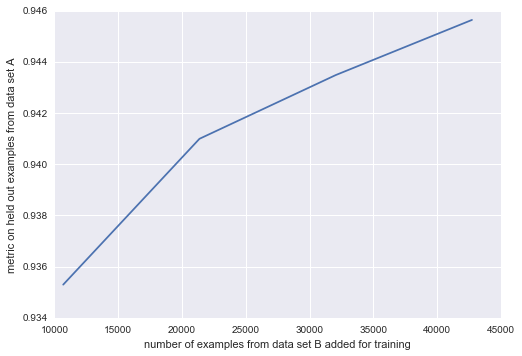

time: 3min 33s


In [15]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

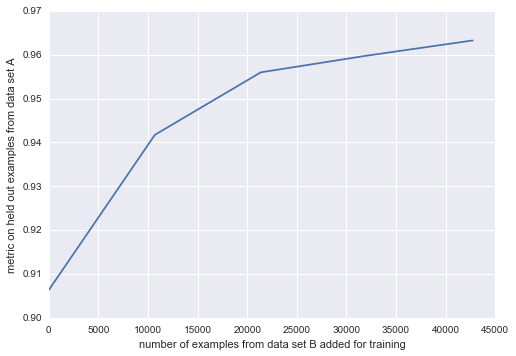

time: 5min 20s


In [16]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

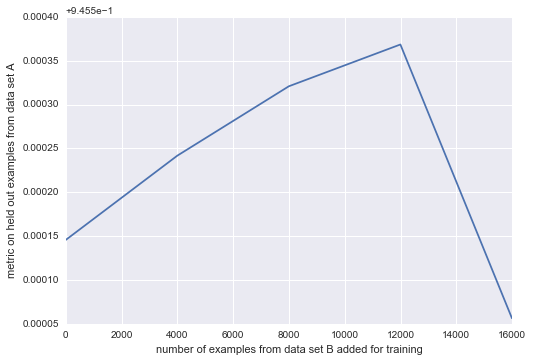

time: 7min 40s


In [17]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc)
plot_adding_other_data(ms, metrics)

# Final Model

In [36]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 1min 50s


# Model Understanding

In [55]:
understanding_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1), analyzer = 'word', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = None)),
])

time: 1.95 ms


In [126]:
model = understanding_pipeline.fit(br_train['x'], br_train['y'])

time: 3.27 s


In [127]:
clf = model.named_steps['clf']

time: 800 µs


In [128]:
coef_ = clf.coef_.ravel()

time: 957 µs


In [129]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())

time: 14.7 ms


In [130]:
most_pos_idx = np.argsort(coef_)[-100:]
most_pos = feature_names[most_pos_idx]

time: 1.72 ms


In [131]:
most_neg_idx = np.argsort(coef_)[:100]
most_neg = feature_names[most_neg_idx]

time: 1.82 ms


In [132]:
most_pos

array(['damn', 'quit', 'shove', 'arsehole', 'dicks', 'nazis', 'ты',
       'homosexual', 'fat', 'pig', 'fuc', 'stop', 'disgusting', 'anal',
       'face', 'yo', 'hate', 'fc', 'retarded', 'piss', 'lick', 'arse',
       'douche', 'head', 'wanker', 'smell', 'dickhead', 'jackass', 'penis',
       'balls', 'ck', 'fuckers', 'arrogant', 'life', 'nazi', 'pussy',
       'prick', 'ing', 'are', 'nigga', 'jerk', 'sex', 'youre', 'hole',
       'fuk', 'scum', 'nigger', 'gay', 'idiotic', 'yourself', 'douchebag',
       'kiss', 'little', 'fuckin', 'loser', 'fag', 'screw', 'dumbass',
       'bullshit', 'pathetic', 'ugly', 'cocksucker', 'coward', 'crap',
       'hypocrite', 'assholes', 'ignorant', 'hell', 'ur', 'idiots',
       'motherfucker', 'retard', 'kill', 'dumb', 'fuckhead', 'racist',
       'go', 'fucked', 'fool', 'off', 'faggot', 'cock', 'die', 'cunt',
       'shut', 'fucker', 'bastard', 'dick', 'ass', 'moron', 'bitch',
       'shit', 'suck', 'your', 'asshole', 'stupid', 'idiot', 'fucking',
    

time: 1.99 ms


In [133]:
most_neg

array(['thank', 'help', 'thanks', 'please', 'he', 'talk', 'to', 'they',
       'this', 'for', 'user', 'appreciate', 'if', 'song', 'articles',
       'issue', 'but', 'request', 'hi', 'him', 'welcome', 'love',
       'discussion', 'the', 'see', 'interested', 'billcj', 'against',
       'position', 'agree', 'username', 'comment', 'continue', 'suggest',
       'understand', 'might', 'at', 'reported', 'these', 'rfa', 'can',
       'great', 'cannot', 'riot', 'interesting', 'cool', 'notice', 'title',
       'section', 'editing', 'should', 'questions', 'hes', 'utc',
       'knowledge', 'al', 'is', 'saying', 'fix', 'article', 'work',
       'could', 'cheers', 'yes', 'response', 'we', 'also', 'there',
       'blocked', 'new', 'particular', 'from', 'music', 'dreadstar',
       'once', 'notable', 'through', 'simply', 'his', '2006',
       'contributions', 'summaries', 'currently', 'evidence', 'would',
       'january', 'link', 'more', 'luck', 'done', 'list', 'include',
       'worry', 'did', 'poin

time: 1.85 ms


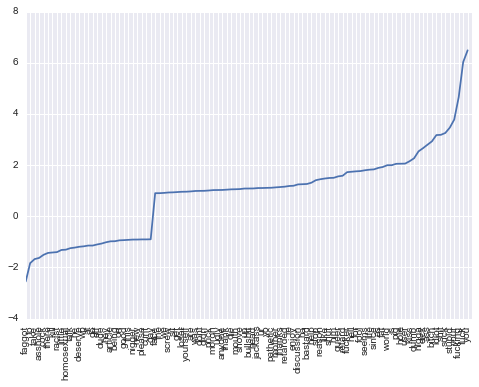

time: 644 ms


In [117]:
"""
coef = coef_.ravel()[important]
inds = np.argsort(coef)
f_imp = f_imp[inds]
coef = coef[inds]
plt.plot(coef, label="l1")
ax = plt.gca()
ax.set_xticks(np.arange(len(coef)))
labels = ax.set_xticklabels(f_imp)
for label in labels:
    label.set_rotation(90)
plt.show()

"""